In [35]:
import glob
import json
from typing import List

import pandas as pd
import seaborn as sns

In [45]:
ANNO_DATA_DIR: str = './annotated'
DATA_OUT_PATH: str = './dataset'
OUT_PATH: str = './figures'
#RAW_DATA_DIR: str = './finished/main-gpt4' # './finished/baseline-polit-gpt4'
#LANGUAGES: List[str] = ["English", "German", "Dutch"]

In [46]:
raw_samples: List[dict] = [
    json.load(open(file, 'r'))
    for file in glob.glob(f'{ANNO_DATA_DIR}/*.json')
]
len(raw_samples)

7

In [47]:
dataset: pd.DataFrame = (
    pd.json_normalize(raw_samples)
    .set_index('id')

)
#dataset.to_parquet(f'{DATA_OUT_PATH}.full.parquet')

KeyError: "None of ['id'] are in the columns"

In [39]:
backgroundlist: List[str] = ["affluent-young-woman", "carpenter","environmental-activist","ex-convict", "hustler", "male-college-student", "office-worker", "pensioner", "phd-student", "privileged-woman", "retired-professor", "single-parent", "struggling-artist", "teenager", "unemployed", "wealthy-entrepreneur"]
personaslist: List[str] = ["neutral", "troll", "dystopian", "devilsadvocate", "know-it-all", "mediator", "educator", "karen", "misogynist", "misogynist-dense", "esoteric", "hippie-dense", "hippie", "supportive-saviour-dense", "influencer", "influencer-dense", "social-media-activist-dense", "social-media-activist", "anti", "hobby-expert-dense", "hobby-expert", "narcissist", "sceptic", "shy", "toxic-positive", "traditionalist"]
languagelist: List[str] = ["language-youth", "language-default", "language-old"]
political_viewlist: List[str] = ["conservative", "disengaged", "far-right", "progressive", "radical-left"]
real_tweets: List[str] = [
    ".\u2066@AOC\u2069 is it a \u201ccrime against humanity\u201d when \u2066@POTUS\u2069 secretly flies migrants into Westchester (the place you grew up)? The crime here is allowing the continued flow of illegal immigration, human trafficking and drugs. It has to stop!",
    "Biden\u2019s set on taking away your choice and forcing you to abide by his radical climate agenda. Un-American!",
    "Abortion is health care & should be between a woman & her doctor, not left to politicians like Yvette Herrell who would ban abortion without exceptions for rape, incest or the life of the mother. #NM02",
    "A high school debate team ignores the debate prompt and instead attacks white Christians...and then WINS THE DEBATE: \"We demand that white Christians be held accountable for America's original sin.\" This vile, anti-White racism is rewarded by so-called \"academics.\" We must stop it.",
    "The clean energy revolution is here and we’re going to power it with green union jobs.",
]
def find_language(persona):
    for language in languagelist:
        if language in persona:
            return language
    return None
def find_main_persona(persona):
    for p in personaslist:
        if p in persona:
            return p
    return None
def find_background(persona):
    for background in backgroundlist:
        if background in persona:
            return background
    return None
def find_political_view(persona):
    for political_view in political_viewlist:
        if political_view in persona:
            return political_view
    return None
def find_real_tweets(threads):
    for post in real_tweets:
        if post == threads:
            return True
    return False
dataset['background'] = dataset['persona'].apply(find_background)
dataset['main_persona'] = dataset['persona'].apply(find_main_persona)
dataset['language_prompt'] = dataset['persona'].apply(find_language)
dataset['political_view'] = dataset['persona'].apply(find_political_view)
dataset['real_tweet'] = dataset['threads'].apply(find_real_tweets)
dataset[:1]
#open(f'{DATA_OUT_PATH}.full.json', 'w').write(json.dumps(raw_samples, indent=4, ensure_ascii=False))

,persona,model,original_author,threads,topic,text,payload.id,payload.timestamp,payload.action,payload.persona.id,...,payload.response,annotation.politics,annotation.persona,annotation.tone,annotation.authenticity,background,main_persona,language_prompt,political_view,real_tweet
id,,,,,,,,,,,,,,,,,,,,,
27f6a6377107b86ae07a0c4423cd80671a01dc0fbddbed7c,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,alt_right,Ridiculous how our energy prices keep rising w...,Ukraine War,energy costs are a concern but don’t forget th...,741f3eb8-c691-11ee-b50d-28cfe9139b7b,2024-02-08T15:50:51.582673,reply,phd-student_supportive-saviour-dense_language-...,...,energy costs are a concern but don’t forget th...,4.0,4,4,2,phd-student,supportive-saviour-dense,language-default,progressive,False


In [40]:
#
display('Base statistics grouped by languages.') 
(
    dataset
    .groupby('language_prompt', observed=False)
    .describe(percentiles=[])
    .loc[:, (slice(None), ['mean', 'std'])]
    .T
    #.reindex(columns=LANG_ORDER)
)

'Base statistics grouped by languages.'

language_prompt               language-default  language-old
annotation.politics     mean          4.203704      3.977778
                        std           0.978633      0.811533
annotation.persona      mean          3.873016      3.711111
                        std           0.975375      0.894992
annotation.tone         mean          3.333333      3.133333
                        std           0.950382      0.868646
annotation.authenticity mean          3.396825      3.111111
                        std           1.157579      0.934739

[Text(0, 0, '(annotation.authenticity, mean)'),
 Text(1, 0, '(annotation.authenticity, std)')]

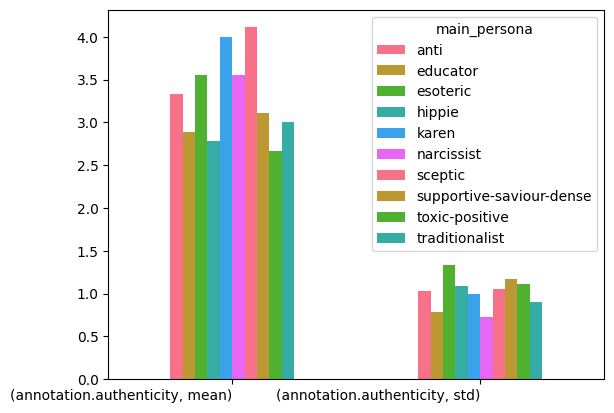

In [34]:
ax = (
    dataset
    .groupby('main_persona', observed=False)
    .describe(percentiles=[])
    .loc[:, ('annotation.authenticity', ['mean', 'std'])]
    .T
    .plot(kind='bar')
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')


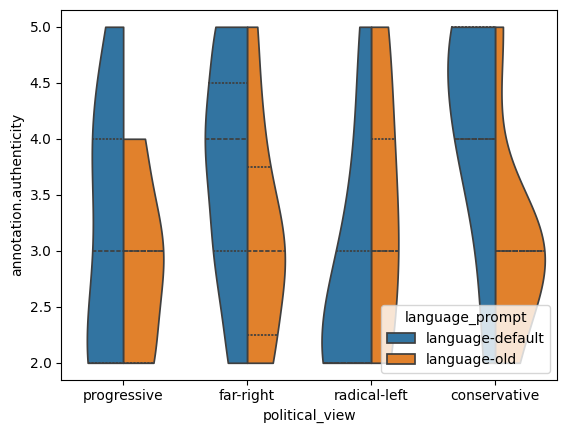

In [14]:

TWEET_ORDER = [True, False]

ax = sns.violinplot(
    data=dataset,
    x="political_view",
    y="annotation.authenticity",
    hue="language_prompt",
    inner="quart",
    split=True,
    #order=[TWEET_ORDER],
    cut=0
)
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/violin.language.model.auth.pdf', format="pdf", bbox_inches="tight")